# Which Countries Love America the Most?
In this project, we extract US favorability from the quotations provided in the QuoteBank dataset.
The steps are as follows:
1. Load the dataset chunk by chunk and apply a keyword filter
2. Drop quotes with "None" speakers
3. Add the nationality of speakers to the dataframe
4. Extract the sentiment of the quotes using a sentiment analysis library
5. Show US favorability for every country
6. Load PEW Research Center Dataset and describe it
7. Compare the datasets of PEW and QuoteSentiment


## 1. Load QuoteBank
In this section, we show how to load the data and apply a filter to extract the quotes with special keywords.
However, this step is done on **Google Colab** because the process is faster.
The output files are saved in the colab and downloaded to have them locally.

The following code is run on Google Colab:



In [ ]:
import bz2
import json

keywords = ["US ", "U.S", "USA", "United States"]

for year in range(2015, 2021) :
  path_to_file = '/content/drive/MyDrive/us_data/Quotebank/quotes-'+year+'.json.bz2'
  path_to_out = '/content/drive/MyDrive/us_data/Filtered_data/quotes-'+year+'-us.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
      with bz2.open(path_to_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              quote = instance['quotation'] # extracting list of links
              if any(word in quote for word in keywords) :
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

## 2. Load US-filtered data locally
In this part, we load the filtered data year by year and concatenate into a single dataframe.
However, since our goal is to categorize the quotations by their speaker's nationality, we need to ignore the quotes
whose speaker is "None".

In [4]:
import pandas as pd

# Get the index of None speaker quo
def drop_none_speaker(year, df):
    print("Year : {} with {} quotes".format(year, len(df)))
    drop_mask = df[df.speaker == "None"].index
    df_dropped = df.drop(drop_mask)
    print("{} quotes are removed".format(len(drop_mask)))
    return df_dropped

US_data = pd.DataFrame()
for year in range(2015, 2021) :
    year_df = pd.read_json('input/quotes-{}-us.json.bz2'.format(year), lines=True, compression='bz2')
    year_df = drop_none_speaker(year, year_df)
    US_data = pd.concat([US_data, year_df], axis=0)

US_data.sample(n=10)



Year : 2015 with 190401 quotes
65755 quotes are removed
Year : 2016 with 135853 quotes
49131 quotes are removed
Year : 2017 with 287824 quotes
111718 quotes are removed
Year : 2018 with 304737 quotes
116832 quotes are removed
Year : 2019 with 255897 quotes
96480 quotes are removed
Year : 2020 with 60896 quotes
23040 quotes are removed


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
7487,2017-03-14-113221,We have the opportunity to use the United Stat...,Ruffy Biazon,[Q7377943],2017-03-14 17:20:05,1,"[[Ruffy Biazon, 0.7126], [None, 0.1732], [Delf...",[http://abs-cbnnews.com/news/03/15/17/ph-shoul...,E
36251,2015-05-13-013874,Greek inspired wobbles in Europe and the US an...,Michael McCarthy,"[Q1933317, Q20010903, Q20642389, Q3308368, Q68...",2015-05-13 02:30:52,1,"[[Michael McCarthy, 0.824], [None, 0.176]]",[http://www.smartcompany.com.au/finance/46910-...,E
58332,2020-03-19-062858,The fact that anyone can really qualify for th...,Rory McIlroy,[Q380613],2020-03-19 12:01:00,2,"[[Rory McIlroy, 0.4448], [Brooks Koepka, 0.281...",[http://www.yorkshirecoastradio.com/news/sport...,E
121048,2019-06-24-071091,some Palestinian leaders... are hoping to run ...,Daoud Kuttab,[Q4142997],2019-06-24 10:31:50,1,"[[Daoud Kuttab, 0.8826], [None, 0.1101], [Benj...",[http://www.middleeasteye.net/opinion/palestin...,E
143150,2015-07-21-091242,The Portland Marathon is honored to be a found...,Les Smith,"[Q3233513, Q6529990]",2015-07-21 20:01:00,5,"[[Les Smith, 0.7222], [None, 0.2778]]",[http://feeds.businesswire.com/click.phdo?i=06...,E
90663,2016-07-28-102188,there has never been a man or a woman more qua...,Michelle Obama,[Q13133],2016-07-28 04:03:53,1,"[[Michelle Obama, 0.7102], [None, 0.2272], [Pr...",[http://rollcall.com/news/politics/amid-tight-...,E
257488,2017-08-03-042134,I am genuinely concerned about what the U.S. A...,David Simon,"[Q16204778, Q2674039, Q47467723, Q57026161, Q5...",2017-08-03 22:51:11,1,"[[David Simon, 0.7809], [None, 0.2052], [Henry...",[http://www.newsday.com/long-island/crime/lett...,E
248952,2018-09-03-048560,our country is doing better than ever before w...,President Trump,[Q22686],2018-09-03 12:21:35,3,"[[President Trump, 0.4223], [None, 0.292], [Ri...",[http://www.dailysabah.com/economy/2018/09/03/...,E
140764,2018-11-18-051077,"The statistics we have been comparing, from th...",Connor Davis,[Q23902506],2018-11-18 04:16:39,2,"[[Connor Davis, 0.9651], [None, 0.0349]]",[https://citizentv.co.ke/news/south-africa-can...,E
9348,2017-09-09-063695,The United States and Kuwait both recognize th...,Rex Tillerson,[Q331401],2017-09-09 00:00:00,2,"[[Rex Tillerson, 0.6789], [None, 0.3038], [Pre...",[https://www.rferl.org/a/trump-urges-saudi-ara...,E


## 3. Add nationality to the main df
In this part, we use the speaker attributes dataset provided on the project web page. We need only id and nationality of
 the speakers; therefore, we keep these two columns. Then, we map the speaker id in Quotebank to this library.

In [5]:
speaker_df = pd.read_parquet("input/speaker_attributes.parquet")
speaker_df = speaker_df[['id', 'nationality']]
speaker_df.head()


,id,nationality
0,Q23,"[Q161885, Q30]"
1,Q42,[Q145]
2,Q1868,[Q31]
3,Q207,[Q30]
4,Q297,[Q29]


In [7]:
US_data["speaker_id"] = US_data.qids.map(lambda x: x[0])

#join US_data with the corresponding speakers' attributes
US_merged = pd.merge(US_data, speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
US_merged.sample(n=5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality
318876,2016-07-06-074195,Our report confirms that decisions about the s...,Kevin Brady,"[Q472241, Q6395881]",2016-07-06 23:45:00,6,"[[Kevin Brady, 0.4802], [None, 0.3591], [Eric ...",[http://www.seattletimes.com/nation-world/obam...,E,Q472241,Q472241,[Q30]
531061,2020-02-24-014194,Foreign import barriers and exports subsidies ...,Martin Feldstein,[Q1904913],2020-02-24 16:07:25,1,"[[Martin Feldstein, 0.8107], [None, 0.1893]]",[http://shadow.foreignpolicy.com/2020/02/24/tr...,E,Q1904913,Q1904913,[Q30]
672213,2017-10-13-023675,Dubai is the gateway to the IT destinations in...,Naresh Kumar,"[Q21531065, Q28672820, Q41680462, Q57064765, Q...",2017-10-13 18:36:40,1,"[[Naresh Kumar, 0.4366], [None, 0.3845], [N. C...",[http://www.thehindu.com/news/national/andhra-...,E,Q21531065,Q21531065,[Q668]
140052,2017-06-27-130418,What I said was climate is changing. Always ha...,Rick Perry,[Q215057],2017-06-27 21:59:04,1,"[[Rick Perry, 0.8475], [Ernest Moniz, 0.0919],...",[https://www.dallasnews.com/news/politics/2017...,E,Q215057,Q215057,[Q30]
356883,2018-06-06-100445,The United States does not have a serious cybe...,Ben Sasse,[Q16192221],2018-06-06 19:50:25,1,"[[Ben Sasse, 0.7823], [None, 0.2177]]",[http://www.nebraska.tv/news/local-politics/ne...,E,Q16192221,Q16192221,[Q30]


Now, we have the speaker's nationality. However the nationality is coded as Q_i where i is an integer.
To translate this id to the name of the country we use *Wikidata API* to create a dictionary of country ids and names.



In [8]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
country_dict

{'Q889': 'Afghanistan',
 'Q222': 'Albania',
 'Q262': 'Algeria',
 'Q228': 'Andorra',
 'Q916': 'Angola',
 'Q781': 'Antigua and Barbuda',
 'Q414': 'Argentina',
 'Q399': 'Armenia',
 'Q408': 'Australia',
 'Q40': 'Austria',
 'Q227': 'Azerbaijan',
 'Q398': 'Bahrain',
 'Q902': 'Bangladesh',
 'Q244': 'Barbados',
 'Q184': 'Belarus',
 'Q31': 'Belgium',
 'Q242': 'Belize',
 'Q962': 'Benin',
 'Q917': 'Bhutan',
 'Q750': 'Bolivia',
 'Q225': 'Bosnia and Herzegovina',
 'Q963': 'Botswana',
 'Q155': 'Brazil',
 'Q921': 'Brunei',
 'Q219': 'Bulgaria',
 'Q965': 'Burkina Faso',
 'Q967': 'Burundi',
 'Q424': 'Cambodia',
 'Q1009': 'Cameroon',
 'Q16': 'Canada',
 'Q1011': 'Cape Verde',
 'Q929': 'Central African Republic',
 'Q657': 'Chad',
 'Q298': 'Chile',
 'Q739': 'Colombia',
 'Q970': 'Comoros',
 'Q800': 'Costa Rica',
 'Q224': 'Croatia',
 'Q204920': 'Crown of Aragon',
 'Q241': 'Cuba',
 'Q229': 'Cyprus',
 'Q213': 'Czech Republic',
 'Q1008': "Côte d'Ivoire",
 'Q756617': 'Danish Realm',
 'Q974': 'Democratic Republic 

In [14]:
# Add nationality of speaker from the country dictionnary
US_with_nation = US_merged.explode('nationality')
US_with_nation.nationality = US_with_nation.nationality.map(country_dict)
US_with_nation.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality
341101,2018-02-11-063725,"The thing in our training, what they tell us i...",Richard Frank,[Q1003530],2018-02-11 08:00:00,1,"[[Richard Frank, 0.732], [None, 0.268]]",[http://www.montereyherald.com/events/20180211...,E,Q1003530,Q1003530,Hungary
280657,2018-05-24-077649,lords & commoners' system. That sucks. US foug...,Elon Musk,[Q317521],2018-05-24 21:02:08,1,"[[Elon Musk, 0.805], [None, 0.1474], [Dennis W...",[https://www.freep.com/story/money/cars/2018/0...,E,Q317521,Q317521,United States of America
9700,2017-08-16-093126,"Mr. President, I join you in advancing the cau...",President Donald Trump,[Q22686],2017-08-16 17:45:05,2,"[[President Donald Trump, 0.6919], [None, 0.30...",[http://gantdaily.com/2017/08/16/by-leaving-tr...,E,Q22686,Q22686,United States of America
53342,2018-02-28-089282,new civil rights movement in the United States.,Jorge Ramos,"[Q1981462, Q56808142, Q6278531]",2018-02-28 22:00:14,1,"[[Jorge Ramos, 0.8809], [None, 0.1191]]",[https://www.newsbusters.org/blogs/latino/mrc-...,E,Q1981462,Q1981462,Mexico
465613,2016-05-30-085731,would be a major definite public announcement ...,Haruna Iddrisu,[Q16211514],2016-05-30 19:04:41,3,"[[Haruna Iddrisu, 0.6836], [None, 0.3164]]",[http://www.ghananewsagency.org/social/progres...,E,Q16211514,Q16211514,Ghana


## 4. Get Sentiments
In this part, we get the sentiment of the quotes. We use a pre-trained library to extract the sentiment.
Any other libraries can be replaced here. In this milestone we used *nltk* because it is faster than other famous libraries.
For the next milestone, the library may be changed.

In [15]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
sia = SentimentIntensityAnalyzer()
# predict the sentiment of each quotation in the range [-1, 1]
US_with_nation["sentiment"] = US_with_nation.quotation.apply(lambda x: sia.polarity_scores(x)["compound"])
US_with_nation.sample(n=5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality,sentiment
686080,2017-11-13-075673,"My mother, Sonia, started Para-Plus after comi...",Robert Santiago,[Q3436235],2017-11-13 13:00:00,1,"[[Robert Santiago, 0.8124], [None, 0.178], [So...",[http://www.onenewspage.com/n/Press Releases/7...,E,Q3436235,Q3436235,France,0.7162
737455,2019-12-12-089399,This brings the total number of F-35A's that a...,Linda Reynolds,[Q16735152],2019-12-12 00:26:00,3,"[[Linda Reynolds, 0.9465], [None, 0.0535]]",[http://theherald.com.au/story/6539770/seven-n...,E,Q16735152,Q16735152,Australia,0.0772
298256,2016-07-23-054967,The fact that U.S. companies are selling plane...,Todd Harrison,"[Q30123000, Q7812419]",2016-07-23 19:40:26,1,"[[Todd Harrison, 0.6941], [None, 0.3059]]",[http://politifact.com/texas/statements/2016/j...,E,Q30123000,Q30123000,NaN,0.7190
137175,2017-12-06-174684,with U.S. law and policy.,Rex Tillerson,[Q331401],2017-12-06 21:46:39,1,"[[Rex Tillerson, 0.7725], [Nikki Haley, 0.1248...",[https://patriotpost.us/articles/52782],E,Q331401,Q331401,United States of America,0.0000
162928,2015-09-15-111096,U.S.-India Economic Ties: Ready for Takeoff?,Penny Pritzker,[Q293365],2015-09-15 17:25:31,2,"[[Penny Pritzker, 0.6515], [None, 0.2659], [Pi...",[http://www.thehindu.com/news/international/bi...,E,Q293365,Q293365,United States of America,0.3612


## 5. Billion-Dollar Question: How much people love US?
In this part, we show the US favorability using the quotes. The sentiment average and the number of quotes for each country
is represented in the following figures.

<AxesSubplot:title={'center':'Number of quotes'}, ylabel='nationality'>

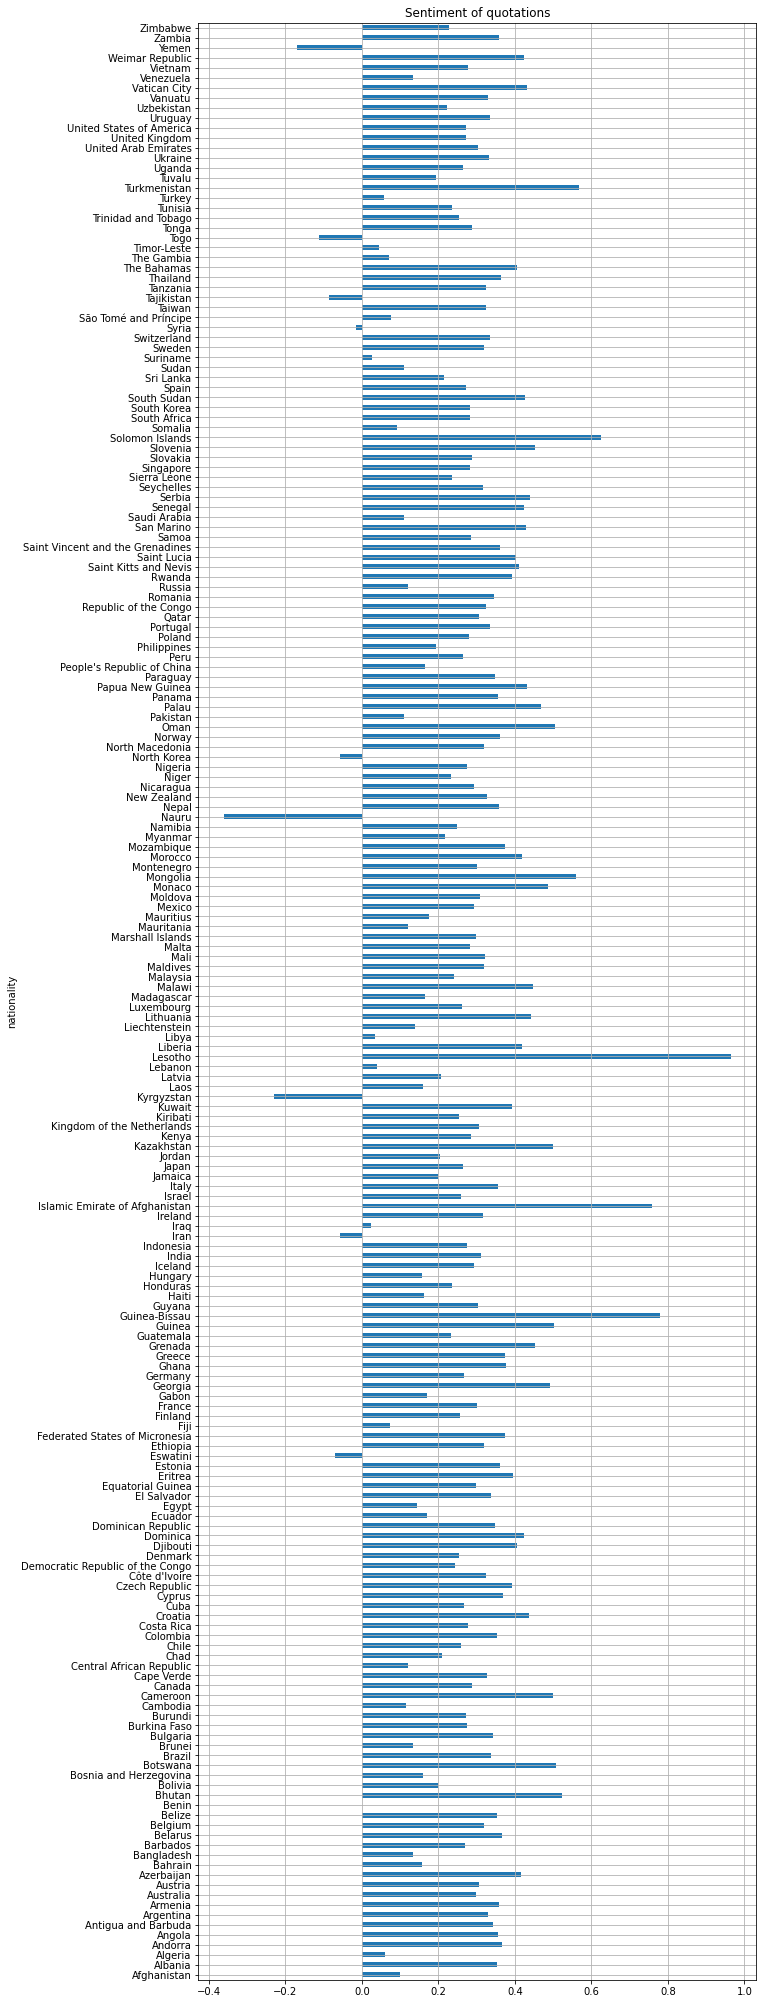

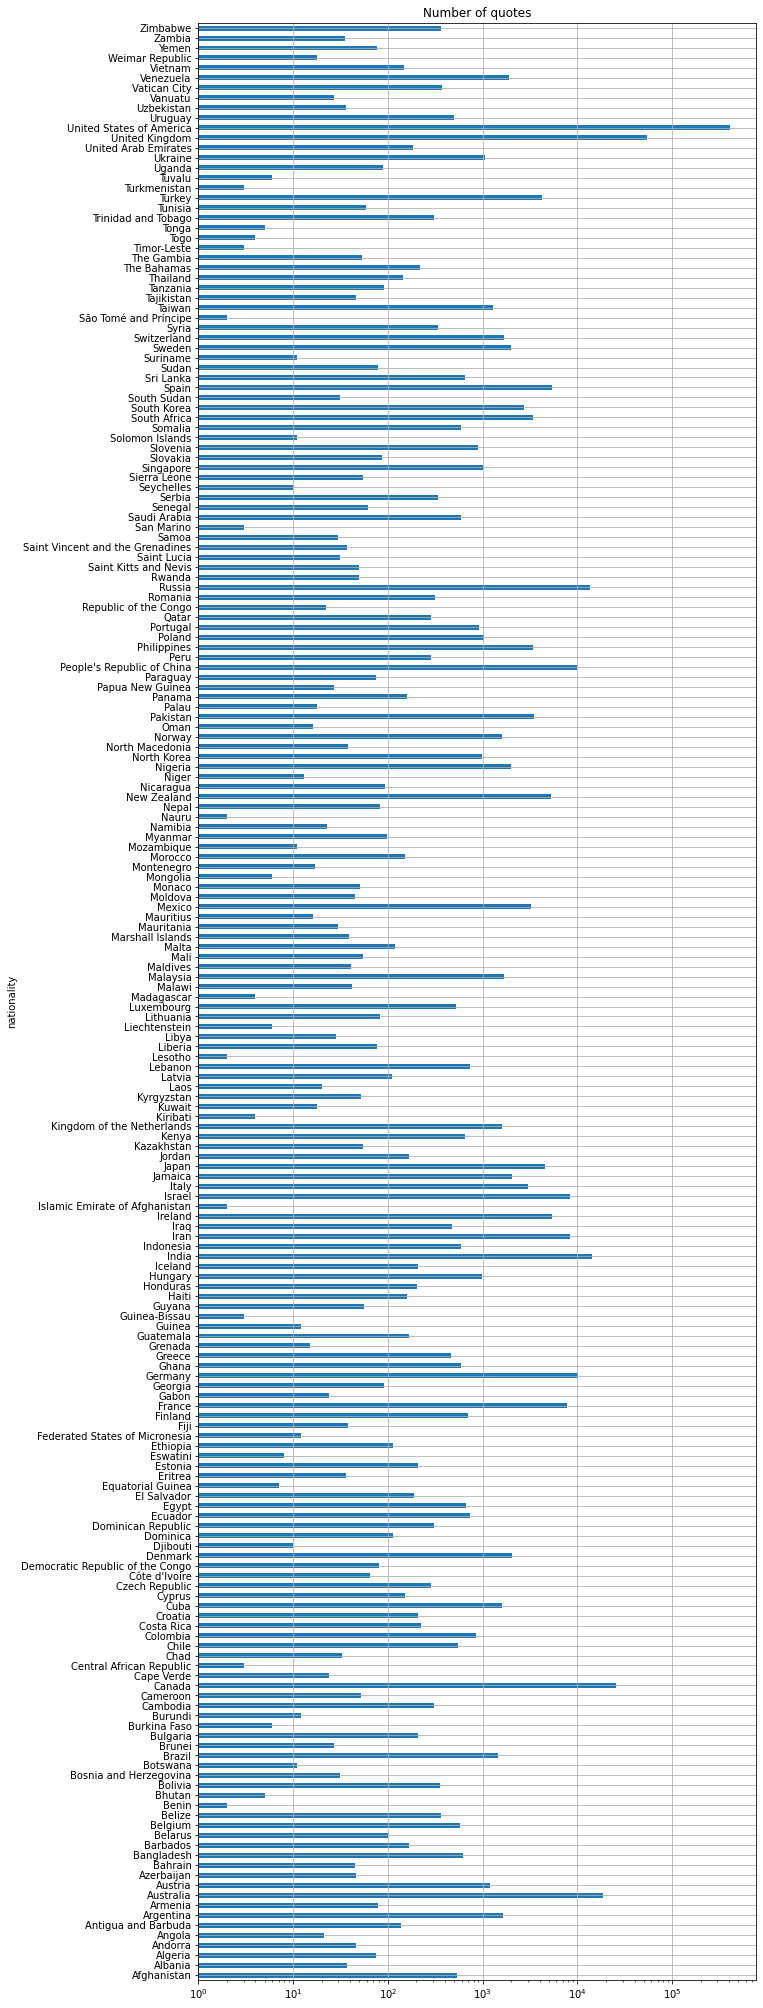

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 36))
plt.title("Sentiment of quotations")
#average sentiment for each country
US_love_mean = US_with_nation.groupby("nationality")["sentiment"].mean()
US_love_mean.plot.barh(grid=True)

plt.figure(figsize=(10,36))
plt.title("Number of quotes")
#count the number of quotes for each country
US_with_nation.groupby("nationality")["sentiment"].count().plot.barh(grid=True, log=True, align='center')


To make a brief analysis, in overall, most the countries seem at first sight more favorable to the USA.. Unsuprisingly the distribution of the number of quotes per country is highly non-uniform.

#### Map creation

In [22]:
import geopandas
#load world map dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#connect US_data with map dataframe
table = world.merge(US_love_mean, how="left", left_on=['name'], right_on=['nationality'])


# Clean data: remove rows with no data
table = table.dropna(subset=['sentiment'])

In [24]:
import folium

#create Map object to do the plot
my_map = folium.Map()

# Map parameters with as color foreach country its sentiment average
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'sentiment'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment of Quotes',
    missing_kwds={'color': 'white'}
).add_to(my_map)

#Save Map figure
my_map.save('us_love.html')

## 6. Load PEW Research Center Dataset

In this section, the datasets provided by PEW research center are loaded and processed.
We extract the nationality, sex, age of the participants and also their answer to the question: "How much you like the
United States?"

In [16]:
!pip install pyreadstat

In [25]:
column_names = ['country', 'fav_us', 'sex', 'age']

#columns labels foreach year (have changed over time)
#"fav_US" denoting their negative or positive view (i.e. their "sentiments") towards the U.S.A.
columns = {2015: ['COUNTRY', 'Q12A', 'Q145', 'Q146'],
           2016: ['country', 'Q10A', 'q107', 'q108'],
           2017: ['Country', 'fav_US', 'sex', 'age'],
           2018: ['COUNTRY', 'fav_US', 'sex', 'age'],
           2019: ['country', 'FAV_US', 'SEX', 'AGE'],
           2020: ['country', 'fav_US', 'sex', 'age']}

pew = pd.DataFrame()

for year in range(2015, 2021):
    #create dataframe from PEW dataset
    pew_year = pd.read_spss("input/pew/{}.sav".format(year))
    pew_year_fav = pew_year[columns[year]]
    pew_year_fav.columns = column_names
    pew_year_fav['year'] = year
    #concat each year to one dataframe
    pew = pd.concat([pew, pew_year_fav], axis=0, ignore_index=True)

#Save the pew dataframe
pew.to_csv('pew.csv', index=False)


/tmp/ipykernel_10549/1589571646.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pew_year_fav['year'] = year


In [29]:
import numpy as np

#List of "invalid" answers in pew dataset
Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
       '(VOL) Refused', "(VOL)\xa0Don't know"]

pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

#map "sentiment" to float values
fav_dict = {'Somewhat favorable': 0.5, 'Very favorable':1,
       'Somewhat unfavorable':-0.5, 'Very unfavorable':-1}

pew = pew.replace(fav_dict)


pew.sample(n=5)


,country,fav_us,sex,age,year
97299,Venezuela,NaN,Male,24.0,2017
130289,Japan,-0.5,Male,76.0,2018
159825,Kenya,1.0,Male,24.0,2019
179934,United States,-0.5,Female,45.0,2020
140726,Mexico,-1.0,Female,61.0,2018


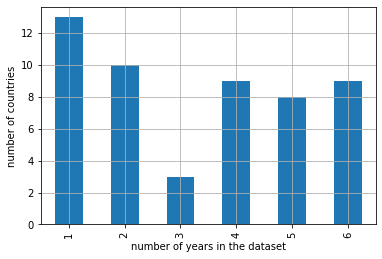

In [30]:
# foreach country, count the number of years it has appeared in the PEW yearly report
# then count the number of country who has appeared 1, 2, 3 times, etc...
pew.groupby('country')['year'].nunique().value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('number of years in the dataset')
plt.ylabel('number of countries')
plt.grid()


As we can see, there is few countries that have been analysed over all the years (only 9), and in total only around 50 countries appears in their reports.

### 7. Compare the datasets of PEW and QuoteSentiment

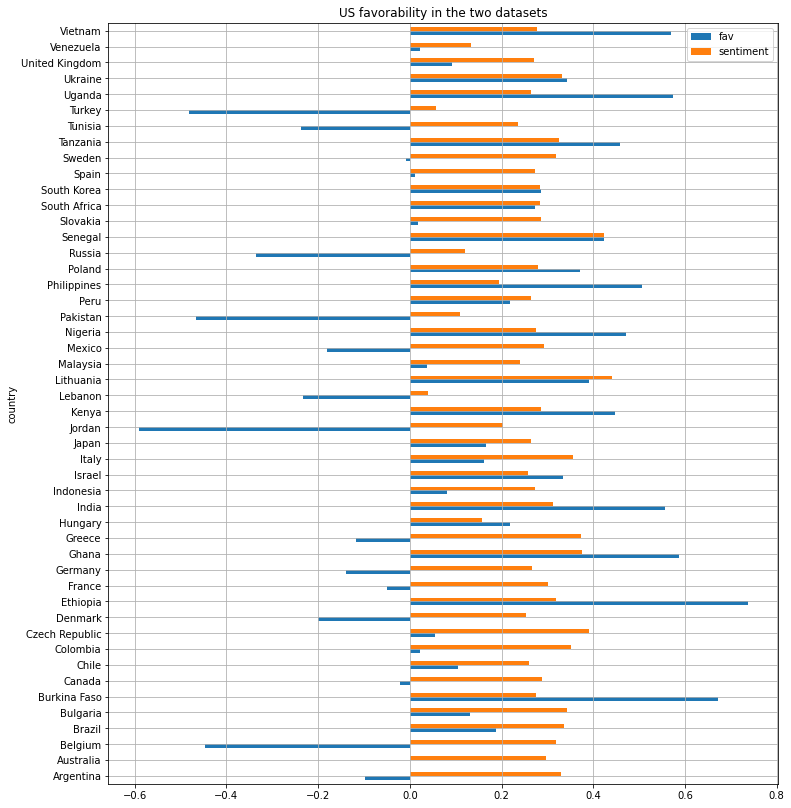

In [31]:
#Compute the mean sentiment for each country from the pew dataset report
pew_fav_us = pew.groupby('country')['fav_us'].mean().reset_index(name='fav')
quote_fav_us = US_love_mean.reset_index()
# merge the results of our sentiment analysis and the results of the pew dataset to create the plot
pew_quote_df = pd.merge(left=pew_fav_us, right=US_love_mean, left_on='country', right_on='nationality')

pew_quote_df.plot(x= 'country', figsize=(12,14), kind='barh')
plt.title("US favorability in the two datasets")
plt.grid()

It appears that there is a large difference between the quotations sentiment analysis we have made and the one made in the pew study. We should not forget that this first analysis was made over a small dataset containing just one year.